<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este projeto baseia-se na criação de um Modelo de Regressão para Previsão do Consumo de Energia. </i>       
</p>  

# <font color='red' style='font-size: 40px;'> Problemática </font>
<hr style='border: 2px solid red;'>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i>  Este projeto tem o intuito de ser um Modelo de Machine Learning para prever o consumo de eletricidade com base em metadados de construção, utilizando histórico e dados meteorológicos. O conjunto de dados inclui leituras de medidores por hora de 100 edifícios em vários locais diferentes ao redor do mundo.


</i> 
</p>  

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> 
</i> 
</p>  


https://www.kaggle.com/competitions/predicting-electricity-consumption/data


# <font color='red' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid red;'>

In [1]:
## Bibliotecas De Manipulação de Dados e Visualização
import pandas as pd 
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, Row, functions as F 
from pyspark.sql.functions import * 
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display, Image

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.diagnostic import lilliefors

# Bibliotecas de Manipulação de Tempo
import time
import datetime

# Bibiliotecas de Seleção de Modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer 
from sklearn.feature_selection import RFE, VarianceThreshold
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection

# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder, BinaryEncoder
import category_encoders as ce 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

# Bibliotecas de Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Bibliotecas de Métricas de Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Parâmetros de Otimização
import warnings
%matplotlib inline
sns.set()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# Spark Session
spark = SparkSession.builder.appName('Model_Energy_Predict').getOrCreate()

# <font color='red' style='font-size: 40px;'> Funções </font>
<hr style='border: 2px solid red;'>

## Funções de Visualização

* Plota Barras 

In [79]:
def plota_barras(lista_variaveis, hue, df, linhas, colunas, titulo):
    if hue != False:
        if (linhas == 1) and (colunas == 1):
            k = 0
            ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', hue = hue)
            ax.set_title(f'{titulo}')
            ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
            ax.set_ylabel(f'Quantidade', fontsize = 14)
            total = []
            for bar in ax.patches:
                height = bar.get_height()
                total.append(height)
            total = sum(total)
            
            sizes = []
            for bar in ax.patches:
                height = bar.get_height()
                sizes.append(height)
                ax.text(bar.get_x() + bar.get_width(),
                        height,
                        f'{round((height/total)*100, 2)}%',
                        ha = 'center',
                        fontsize = 12
                )
            ax.set_ylim(0, max(sizes)*1.1)
            plt.show()
        elif linhas == 1:
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{{{titulo}}}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[j], hue = hue)
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width(),
                                height,
                                f'{round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, max(sizes)*1.1)
                    k = k + 1
        elif colunas == 1:
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{{titulo}}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[i], hue = hue)
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width(),
                                height,
                                f'{round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, max(sizes)*1.1)
                    k = k + 1
        else: 
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{titulo}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[i, j], hue = hue)
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width(),
                                height,
                                f'{round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, max(sizes)*1.1)
                    k = k + 1
    else:
        if (linhas == 1) and (colunas == 1):
            k = 0
            ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', color='#1FB3E5')
            ax.set_title(f'{titulo}')
            ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
            ax.set_ylabel(f'Quantidade', fontsize = 14)
            total = []
            for bar in ax.patches:
                height = bar.get_height()
                total.append(height)
            total = sum(total)
            
            sizes = []
            for bar in ax.patches:
                height = bar.get_height()
                sizes.append(height)
                ax.text(bar.get_x() + bar.get_width(),
                        height,
                        f'{round((height/total)*100, 2)}%',
                        ha = 'center',
                        fontsize = 12
                )
            ax.set_ylim(0, max(sizes)*1.1)
            plt.show()

        elif linhas == 1:
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{titulo}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[j], color='#1FB3E5')
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width(),
                                height,
                                f'{round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, max(sizes)*1.1)
                    k = k + 1
        elif colunas == 1:
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{titulo}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[i], color='#1FB3E5')
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width(),
                                height,
                                f'{round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, max(sizes)*1.1)
                    k = k + 1
        else:
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{titulo}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[i, j], color='#1FB3E5')
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width(),
                                height,
                                f'{round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, max(sizes)*1.1)
                    k = k + 1


* Plota Histogramas 

In [81]:
def plota_histograma(lista_variaveis, df, linhas, colunas, titulo):
    if (linhas == 1) and (colunas == 1): 
        k = 0
        mediana = df[lista_variaveis[k]].median()
        media = df[lista_variaveis[k]].mean().round()
        plt.figure(figsize = (14, 4))
        ax = sns.histplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', bins = 30)
        ax.set_title(f'{titulo}')
        ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
        ax.set_ylabel(f'Frequência', fontsize = 14)
        ax.axvline(x = mediana, ymax = 0.75 ,color = '#231F20', linestyle = '-', label = f'mediana = {mediana}')
        ax.axvline(x = media, ymax = 0.75,color = '#231F20', linestyle = '--', label = f'media = {media}')
        plt.ticklabel_format(style='plain')
        plt.legend(loc = 'best')
        plt.show()
    elif linhas == 1:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        fig.suptitle(f'{titulo}')
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                mediana = df[lista_variaveis[k]].median()
                media = df[lista_variaveis[k]].mean().round()
                ax = sns.histplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[j], bins = 30)
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                ax.axvline(x = mediana, ymax = 0.75 ,color = '#231F20', linestyle = '-', label = f'mediana = {mediana}')
                ax.axvline(x = media, ymax = 0.75,color = '#231F20', linestyle = '--', label = f'media = {media}')
                ax.ticklabel_format(style='plain')
                ax.legend(loc = 'best')
                k = k + 1
    elif colunas == 1:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        fig.suptitle(f'{titulo}')
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                mediana = df[lista_variaveis[k]].median()
                media = df[lista_variaveis[k]].mean().round()
                ax = sns.histplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[i], bins = 30)
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                ax.axvline(x = mediana, ymax = 0.75 ,color = '#231F20', linestyle = '-', label = f'mediana = {mediana}')
                ax.axvline(x = media, ymax = 0.75,color = '#231F20', linestyle = '--', label = f'media = {media}')
                ax.ticklabel_format(style='plain')
                ax.legend(loc = 'best')
                k = k + 1
    else:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        fig.suptitle(f'{titulo}')
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                mediana = df[lista_variaveis[k]].median()
                media = df[lista_variaveis[k]].mean().round()
                ax = sns.histplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[i, j], bins = 30)
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                ax.axvline(x = mediana, ymax = 0.75 ,color = '#231F20', linestyle = '-', label = f'mediana = {mediana}')
                ax.axvline(x = media, ymax = 0.75,color = '#231F20', linestyle = '--', label = f'media = {media}')
                ax.ticklabel_format(style='plain')
                ax.legend(loc = 'best')
                k = k + 1

* Plota Boxplot

In [4]:
def plota_boxplot(lista_variaveis, df, linhas, colunas, titulo):
    if (linhas == 1) and (colunas == 1): 
        k = 0
        plt.figure(figsize = (14, 4))
        ax = sns.boxplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', orient = 'h')
        ax.set_title(f'{titulo}')
        ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
        ax.set_ylabel(f'Frequência', fontsize = 14)
        plt.show()
    elif linhas == 1:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                ax = sns.boxplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[j], orient = 'h')
                ax.set_title(f'{titulo}')
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                k = k + 1
    elif colunas == 1:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                ax = sns.boxplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[i], orient = 'h')
                ax.set_title(f'{titulo}')
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                k = k + 1
    else:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                ax = sns.boxplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[i, j], orient = 'h')
                ax.set_title(f'{titulo}')
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                k = k + 1

* Plota Dispersão

In [5]:
def plota_dispersao(x, y, dados):
    plt.figure(figsize = (14, 4))
    plt.scatter(data = dados, x = x, y = y, color='#1FB3E5', s = 10, alpha = 0.50, marker = '.')
    plt.title(f'Gráfico de Dispersão entre {x} e {y}', fontsize = 14)
    plt.xlabel(f'{x}', fontsize = 14)
    plt.ylabel(f'{y}', fontsize = 14)
    plt.grid(False)
    plt.box(False)
    plt.ticklabel_format(style='plain')
    plt.legend(loc = 'best')
    plt.show()

## Funções de Estatística

* Analisa Correlação

In [6]:
def analisa_correlacao(metodo, df):
    plt.figure(figsize = (14, 7))
    sns.heatmap(df.corr(method = metodo), vmin = -1, vmax = 1, cmap = 'magma', annot = True)
    plt.title(f"Analisando Correlação de {metodo}")
    plt.grid(False)
    plt.box(False)
    plt.tight_layout()
    plt.show()

* Analisa Normalidade 

In [7]:
def analisa_normalidade(amostra1, amostra2, variavel):

    normaltest_amostra_1 = normaltest(amostra1[variavel])
    normaltest_amostra_2 = normaltest(amostra2[variavel])

    if (normaltest_amostra_1[1] < 0.05 ) and (normaltest_amostra_2[1] < 0.05):
        print(f'Pelo Teste de Hipótese, A Hipótese Nula de que a variável "{variavel}" segue uma Distribuição Normal é REJEITADA!')
    else:
        print(f'Pelo Teste de Hipótese, A Hipótese Nula de  que a variável "{variavel}" segue uma Distribuição Normal é ACEITA')

    ax1 = plt.subplot(121)
    stats.probplot(amostra1[variavel], dist = 'norm', plot = plt)
    plt.title(f'Amostra 1', fontsize = 14)
    plt.grid(False)
    plt.box(False)
    plt.tight_layout()
    ax1 = plt.subplot(122)
    stats.probplot(amostra2[variavel], dist = 'norm', plot = plt)
    plt.title(f'Amostra 2', fontsize = 14)
    plt.grid(False)
    plt.box(False)
    plt.tight_layout()

    
    plt.show()



* Teste de Hipótese para Duas Amostras Independentes 

In [8]:
def teste_hipotese_duas_amostras_independentes(parametrico, amostra1, amostra2, variavel):

    media_amostra_1 = amostra1[variavel].mean()
    media_amostra_2 = amostra2[variavel].mean()
    mediana_amostra_1 = amostra1[variavel].median()
    mediana_amostra_2 = amostra2[variavel].median()

    if parametrico == True: 
        print(f'Média Amostra 1: {media_amostra_1}')
        print(f'Média Amostra 2: {media_amostra_2}')
        stat, p_value = ztest(amostra1[variavel], amostra2[variavel]) 
        if p_value > 0.05:
            print(f'Pelo Teste de Hipótese Z, não há diferença significativa entre as médias da Amostra 1 e Amostra 2')
        else:
            print(f'Pelo Teste de Hipótese Z, há diferença significativa entre as médias da Amostra 1 e Amostra 2')
    else:
        print(f'Mediana Amostra 1: {mediana_amostra_1}')
        print(f'Mediana Amostra 2: {mediana_amostra_2}')
        stat, p_value = stats.mannwhitneyu(amostra1[variavel], amostra2[variavel]) 
        if p_value > 0.05:
            print(f'Pelo Teste de Hipótese de Mann Whitney, não há diferença significativa entre as medianas da Amostra 1 e Amostra 2')
        else:
            print(f'Pelo Teste de Hipótese de Mann Whitney, há diferença significativa entre as medianas da Amostra 1 e Amostra 2')

## Funções de Pré-Processamento

- Cria features de tempo

In [87]:
def features_temporais(train, test):
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])


    train['year'] = train['timestamp'].dt.year
    train['month'] = train['timestamp'].dt.month
    train['day'] = train['timestamp'].dt.day
    train['hour'] = train['timestamp'].dt.hour

    test['year'] = test['timestamp'].dt.year
    test['month'] = test['timestamp'].dt.month
    test['day'] = test['timestamp'].dt.day
    test['hour'] = test['timestamp'].dt.hour

* Separa entre Features e Target 

In [9]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]
    return x, y

- Separa entre Treino e Teste 

In [10]:
def separa_treino_teste_temporal(data, data_teste, dados):
    dados.sort_values(by = data, ascending = True, inplace = True)
    df_train = dados.loc[dados[data] < data_teste]
    df_test = dados.loc[dados[data] >= data_teste]

    return df_train, df_test

## Funções de Métricas ou Avaliação 

In [11]:
def metricas(regressor, target, y_train, y_predict_train, y_test, y_predict_test, coeficiente_det_train, coeficiente_det_test):
    y_test[target].fillna(y_train[target].median(), inplace = True)

    mae_train = mean_absolute_error(y_predict_train, y_train)
    mse_train = mean_squared_error(y_predict_train, y_train)
    mape_train = mean_absolute_percentage_error(y_predict_train, y_train)
    metricas_treino = pd.DataFrame({'Coeficiente de Determinação (R^2)':coeficiente_det_train, 'Erro_Medio_Absoluto':mae_train, 'Erro_Quadratico_Medio':mse_train, 'Media_Percentual_Absoluta_Erro':mape_train, 'Etapa':'treino', 'Regressor':regressor}, index = np.arange(1, 2))


    mae_test = mean_absolute_error(y_predict_test, y_test)
    mse_test = mean_squared_error(y_predict_test, y_test)
    mape_test = mean_absolute_percentage_error(y_predict_test, y_test)
    metricas_teste = pd.DataFrame({'Coeficiente de Determinação (R^2)':coeficiente_det_test, 'Erro_Medio_Absoluto':mae_test, 'Erro_Quadratico_Medio':mse_test, 'Media_Percentual_Absoluta_Erro':mape_test, 'Etapa':'teste', 'Regressor':regressor}, index = np.arange(1, 2))

    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais

def metricas_modelos_juntos(lista_modelos):
    metricas_modelos = pd.concat(lista_modelos).set_index('Regressor')
    return metricas_modelos


* Validação Cruzada 

In [12]:
def validacao_cruzada_regressao(target_type, x_train, y_train, n_splits, regressor):
    categoricas = [column for column in x_train.columns if x_train[column].dtype.name == 'object']
    numericas = [column for column in x_train.columns if (x_train[column].dtype.name == 'int64') or (x_train[column].dtype.name == 'float64')]
    
    pipeline_categoricas = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', BinaryEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    pipeline_numericas = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])
    
    pre_processamento = ColumnTransformer([
        ('cat', pipeline_categoricas, categoricas),
        ('num', pipeline_numericas, numericas)
    ])
    
    if target_type == 'categorico':
        y_train.fillna(y_train.mode()[0], inplace=True)
    else:
        y_train.fillna(y_train.median(), inplace=True)
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    if regressor == 'Regressão Linear Múltipla':
        model = make_pipeline(pre_processamento, LinearRegression())
    elif regressor == 'Random Forest':
        model = make_pipeline(pre_processamento, RandomForestRegressor(n_estimators=100, max_depth=9, criterion='squared_error', random_state=42))
    elif regressor == 'Gradient Boosting':
        model = make_pipeline(pre_processamento, GradientBoostingRegressor(n_estimators=100, max_depth=9, loss='ls', random_state=42))
    else:
        print('Utilize Regressão Linear Múltipla, Random Forest ou Gradient Boosting como opções de Regressores!')
    
    coef_det = cross_val_score(model, x_train, y_train, cv=kfold, scoring='r2').mean()
    mae = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error').mean()
    mse = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error').mean()
    mape = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error').mean()
    
    metricas_finais = pd.DataFrame({'Coeficiente de Determinação (R^2)': coef_det,
                                    'Erro_Medio_Absoluto': mae * -1,
                                    'Erro_Quadratico_Medio': mse * -1,
                                    'Media_Percentual_Absoluta_Erro': mape * -1,
                                    'Etapa': 'validacao_cruzada',
                                    'Regressor': regressor}, index=np.arange(1, 2))
    
    return metricas_finais


## Funções de Machine Learning 

In [13]:
def regressao_linear_multipla(target_type, x_train, y_train, x_test, y_test, otimizacao, numero_features, regularization=None):
    categoricas = [column for column in x_train.columns if x_train[column].dtype.name == 'object']
    numericas = [column for column in x_train.columns if (x_train[column].dtype.name == 'int64') or (x_train[column].dtype.name == 'float64')]
    pipeline_categoricas = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', BinaryEncoder())
    ])
    pipeline_numericas = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ])
    pre_processamento = ColumnTransformer([
        ('cat', pipeline_categoricas, categoricas),
        ('num', pipeline_numericas, numericas)
    ])
    if target_type == 'categorico':
        y_train.fillna(y_train.mode(), inplace=True)
        y_test.fillna(y_train.mode(), inplace=True)
    else:
        y_train.fillna(y_train.median(), inplace=True)
        y_test.fillna(y_train.median(), inplace=True)
    if otimizacao:
        if regularization == 'Lasso':
            model = make_pipeline(pre_processamento, RFE(Lasso(), step=1, n_features_to_select=numero_features))
        elif regularization == 'Ridge':
            model = make_pipeline(pre_processamento, RFE(Ridge(), step=1, n_features_to_select=numero_features))
        else:
            model = make_pipeline(pre_processamento, RFE(LinearRegression(), step=1, n_features_to_select=numero_features))
    else:
        model = make_pipeline(pre_processamento, LinearRegression())
    model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    coef_det_train = round(model.score(x_train, y_train), 2)
    coef_det_test = round(model.score(x_test, y_test), 2)
    return y_predict_train, y_predict_test, coef_det_train, coef_det_test

In [14]:
def regressao_random_forest(target_type, x_train, y_train, x_test, y_test, otimizacao, numero_features):
    categoricas = [column for column in x_train.columns if x_train[column].dtype.name == 'object']
    numericas = [column for column in x_train.columns if (x_train[column].dtype.name == 'int64') or (x_train[column].dtype.name == 'float64')]
    pipeline_categoricas = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', BinaryEncoder())
    ])
    pipeline_numericas = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ])
    pre_processamento = ColumnTransformer([
        ('cat', pipeline_categoricas, categoricas),
        ('num', pipeline_numericas, numericas)
    ])
    if target_type == 'categorico':
        y_train.fillna(y_train.mode(), inplace=True)
        y_test.fillna(y_train.mode(), inplace=True)
    else:
        y_train.fillna(y_train.median(), inplace=True)
        y_test.fillna(y_train.median(), inplace=True)
    model = make_pipeline(pre_processamento, RandomForestRegressor(n_estimators=100, max_depth=9, random_state=42))
    model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    coef_det_train = round(model.score(x_train, y_train), 2)
    coef_det_test = round(model.score(x_test, y_test), 2)

    # Seleção de recursos com base na importância das características
    importances = model.named_steps['randomforestregressor'].feature_importances_
    indices = np.argsort(importances)[::-1]  # Ordenar índices em ordem decrescente
    features_selecionadas = x_train.columns[indices][:numero_features]
    x_train_selecionado = x_train[features_selecionadas]
    x_test_selecionado = x_test[features_selecionadas]

    return y_predict_train, y_predict_test, coef_det_train, coef_det_test, importances, indices, features_selecionadas


In [15]:
def regressao_gradient_boosting(target_type, x_train, y_train, x_test, y_test, otimizacao, numero_features):
    categoricas = [column for column in x_train.columns if x_train[column].dtype.name == 'object']
    numericas = [column for column in x_train.columns if (x_train[column].dtype.name == 'int64') or (x_train[column].dtype.name == 'float64')]
    pipeline_categoricas = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', BinaryEncoder())
    ])
    pipeline_numericas = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ])
    pre_processamento = ColumnTransformer([
        ('cat', pipeline_categoricas, categoricas),
        ('num', pipeline_numericas, numericas)
    ])
    if target_type == 'categorico':
        y_train.fillna(y_train.mode(), inplace=True)
        y_test.fillna(y_train.mode(), inplace=True)
    else:
        y_train.fillna(y_train.median(), inplace=True)
        y_test.fillna(y_train.median(), inplace=True)
    model = make_pipeline(pre_processamento, GradientBoostingRegressor(n_estimators=100, max_depth=9, loss='ls', random_state=42))
    model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    coef_det_train = round(model.score(x_train, y_train), 2)
    coef_det_test = round(model.score(x_test, y_test), 2)

    # Seleção de recursos com base na importância das características
    importances = model.named_steps['gradientboostingregressor'].feature_importances_
    indices = np.argsort(importances)[::-1]  # Ordenar índices em ordem decrescente
    features_selecionadas = x_train.columns[indices][:numero_features]
    x_train_selecionado = x_train[features_selecionadas]
    x_test_selecionado = x_test[features_selecionadas]

    return y_predict_train, y_predict_test, coef_det_train, coef_det_test, importances, indices, features_selecionadas


# <font color='red' style='font-size: 40px;'> 1) Entendimento da Base de Dados </font>
<hr style='border: 2px solid red;'>

### 1.1) Descrição das Variáveis

> 1. 'building_id' : ID da Residência

> 2. 'timestamp' : Quando a medição foi feita.

> 3. 'meter_reading': A variável de destino. Consumo de energia em kWh. (Target)

> 4. 'primary_use':  Indicador da categoria principal de atividades para o edifício com base nas definições de tipo de propriedade EnergyStar.

> 5. 'square_feet': Área bruta do edifício.

> 6. 'year_built': Edifício do ano em que foi inaugurado.

> 7. 'air_temperature': Graus Celsius.

> 8. 'cloud_coverage': Porção do céu coberta por nuvens, em octas.

> 9. 'dew_temperature': Graus Celsius

> 10. 'precip_depth_1_hr': Milímetros

> 11. 'sea_level_pressure': Pressão

> 12. 'wind_direction': Direção do Vento

> 13. 'wind_speed': Velocidade do Vento


### 1.2) Informações Inicais

In [88]:
train = pd.read_csv('../04_modelo_predicao_consumo_energia/data/train.csv')
test = pd.read_csv('../04_modelo_predicao_consumo_energia/data/test.csv')

In [89]:
print(f'Tamanho da Base de Treino: {train.shape[0]}')
print(f'Tamanho da Base de Teste: {test.shape[0]}')

df_nulls_train = pd.DataFrame(train.isnull().sum()).reset_index().rename({'index':'features', 0:'quantidade_nulos_treino'}, axis = 1)
df_nulls_test = pd.DataFrame(test.isnull().sum()).reset_index().rename({'index':'features', 0:'quantidade_nulos_teste'}, axis = 1)
df_null = df_nulls_train.merge(df_nulls_test, on = 'features', how = 'left')
df_null

Tamanho da Base de Treino: 698675
Tamanho da Base de Teste: 174666


,features,quantidade_nulos_treino,quantidade_nulos_teste
0,building_id,0,0.00
1,timestamp,0,0.00
2,meter_reading,0,NaN
3,primary_use,0,0.00
4,square_feet,0,0.00
5,year_built,0,0.00
6,air_temperature,223,74.00
7,cloud_coverage,304516,76178.00
8,dew_temperature,223,74.00
9,precip_depth_1_hr,84,15.00


### 1.3) Tipos de Dados

# <font color='red' style='font-size: 40px;'> 2.0 Análise Exploratória </font>
<hr style='border: 2px solid red;'>

### 2.1) Separando em Treino e Validação



In [44]:
df_train = separa_treino_teste_temporal('timestamp', '2016-12-01', train)[0]
df_valid = separa_treino_teste_temporal('timestamp', '2016-12-01', train)[1]

In [94]:
features_temporais(df_train, df_valid)

display(df_train.head())
display(df_valid.head())

,building_id,timestamp,meter_reading,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour
0,1,2016-01-01,0.00,Education,2720,2004,25.00,6.00,20.00,NaN,1019.70,0.00,0.00,2016,1,1,0
61,76,2016-01-01,0.00,Education,128887,2009,25.00,6.00,20.00,NaN,1019.70,0.00,0.00,2016,1,1,0
59,74,2016-01-01,43.00,Parking,387638,1997,25.00,6.00,20.00,NaN,1019.70,0.00,0.00,2016,1,1,0
58,73,2016-01-01,0.00,Parking,387638,2008,25.00,6.00,20.00,NaN,1019.70,0.00,0.00,2016,1,1,0
57,72,2016-01-01,0.00,Parking,387638,2002,25.00,6.00,20.00,NaN,1019.70,0.00,0.00,2016,1,1,0


,building_id,timestamp,meter_reading,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour
639159,47,2016-12-01,357.28,Retail,31666,2008,21.10,6.00,20.00,3.00,1015.10,180.00,1.50,2016,12,1,0
639126,9,2016-12-01,69.21,Office,27000,2010,21.10,6.00,20.00,3.00,1015.10,180.00,1.50,2016,12,1,0
639120,2,2016-12-01,13.11,Education,5376,1991,21.10,6.00,20.00,3.00,1015.10,180.00,1.50,2016,12,1,0
639121,3,2016-12-01,353.57,Education,23685,2002,21.10,6.00,20.00,3.00,1015.10,180.00,1.50,2016,12,1,0
639122,4,2016-12-01,1403.34,Education,116607,1975,21.10,6.00,20.00,3.00,1015.10,180.00,1.50,2016,12,1,0


> 1. Inicialmente, deve-se separar em Dados de Treino e Dados de Teste para evitar Data Leakage, ou seja, evitar que as informações do teste vazem para o treino

## Funções de Visualização

### 2.2) Distribuições de Variáveis --> Foco em aspectos não climáticos

In [45]:
qt_casas = df_train['building_id'].nunique()
print(f'Quantidade de Casas: {qt_casas}')

Quantidade de Casas: 101


,meter_reading_mean,meter_reading_median,meter_reading_max,meter_reading_min,meter_reading_std
count,101.00,101.00,101.00,101.00,101.00
mean,221.61,296.82,796.78,0.00,197.05
std,248.86,372.60,863.12,0.00,209.06
min,1.57,0.00,5.19,0.00,1.84
1%,3.46,0.00,15.63,0.00,3.74
5%,12.69,6.55,56.08,0.00,13.30
10%,23.00,12.17,87.00,0.00,20.94
25%,66.79,65.94,255.00,0.00,66.83
50%,140.54,176.21,447.00,0.00,133.15
75%,269.76,358.75,1017.00,0.00,237.61


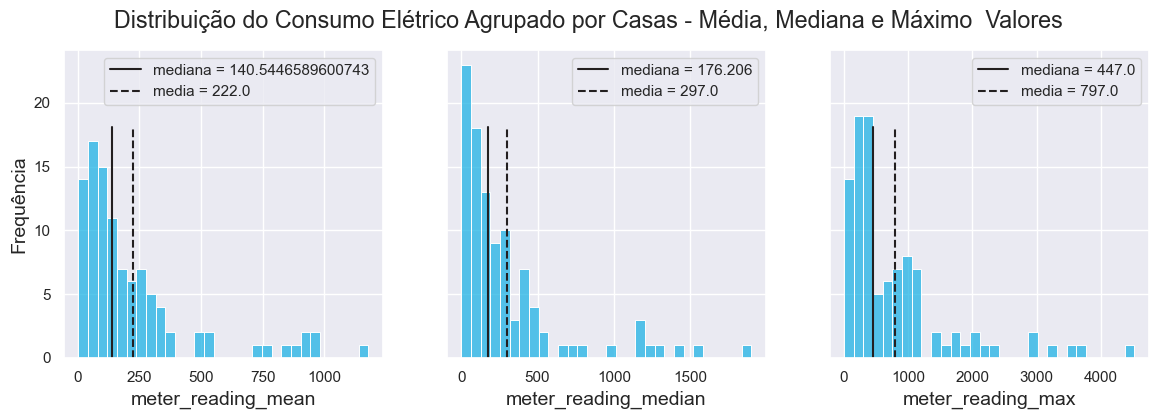

In [85]:
df_train_grouped = (
    df_train
        .groupby('building_id')
        ['meter_reading']
        .agg([
            'mean',
            'median',
            'max',
            'min',
            'std'
        ])
        .rename({
            'mean':'meter_reading_mean',
            'median':'meter_reading_median',
            'max':'meter_reading_max',
            'min':'meter_reading_min',
            'std':'meter_reading_std',
        }, axis = 1)
        .reset_index()
    )

plota_histograma(
    ['meter_reading_mean', 'meter_reading_median', 'meter_reading_max'],
    df_train_grouped, 
    1,
    3,
    'Distribuição do Consumo Elétrico Agrupado por Casas - Média, Mediana e Máximo  Valores'
)    
df_train_grouped.describe(percentiles= [0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 0.90, 0.99])

> 1. Inicialmente, como estamos avaliando o consumo elétrico de 101 casas, o intuito é analisar de forma individual cada casa. Para isso, agrupou-se o consumo em relação a algumas estatísticas descritivas.

> 2. A princípio nota-se que a presença de uma distribuição assimétrica para a direita em relaçao as medições em relação a média, mediana e máximo; logo, conclui-se que a grande parte das casas aparenta não ter um alto gasto de energia, embora haja outliers que tem alto consumo.

> 3. Em relação a média do consumo, ela é influcianda pelos registros contabilizados como 0, levando os números para baixo; em relação a mediana do consumo, uma estatística inerente aos outliers, pode-se ter uma visão um pouco mais fidedigna do consumo; em relação máximo consumo, é possível notar situações as quais o consumo foi elevado por algum motivo em questão.

> 4. As linhas verticais são valores da "média das médias" e "mediana das medianas".

# <font color='red' style='font-size: 40px;'> 3.0 Feature Engineer </font>
<hr style='border: 2px solid red;'>

# <font color='red' style='font-size: 40px;'> 4.0 Aplicação de Modelos de Machine Learning </font>
<hr style='border: 2px solid red;'>

# <font color='red' style='font-size: 40px;'> 5.0 Consolidação dos Resultados </font>
<hr style='border: 2px solid red;'>